# Computational Aspects of Machine Learning

This experiment is in conjunction with the paper submitted for the seminar **Computational Aspects of Machine Learning** at the Technical University of Munich. We compare the some numerical optimizers with respect to their accuracy and time complexity with the help of a simple example. We train a convolutional neural network to classify the well-known MNIST dataset which consists of 60,000 $28 \times 28$ pixel images of hand drawn numbers. We keep all the parameters of our neural network the same except for the Numerical Optimizer utilized to train the network and observe the empirical results.

Source: This experiment was taken from https://nextjournal.com/gkoehler/pytorch-mnist and edited to suit experimentation needs.

### We analyze the following Numerical Optimizers in this experiment with the aid of the well known MNIST dataset.
1. SGD
2. SGD with Momentum
3. Nesterov Momentum
4. Adagrad
5. ADAM
6. LBFGS
8. Hessian Free
9. Newton-CG

## Importing required libraries

In [1]:
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import timeit
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from network import Net

## Setting general hyperparameters

Throughout these experiments we work with the following hyperparameters. In somecases certain parameters are varied which are mentioned in the respective sections where the effect of the change of this parameter is discussed.

In [2]:
h_params = {'n_epochs' : 3,
'batch_size_train' : 64,
'batch_size_test' : 1000,
'learning_rate' : 0.01,
'momentum' : 0.9,
'log_interval' : 10,
'random_seed' : 1
}

# GPU is not available :(
torch.backends.cudnn.enabled = False
torch.manual_seed(h_params['random_seed'])

### Downloading the MNIST Dataset

We classify the well-known MNIST dataset which consists of 60,000, $28 \times 28$ pixel images of hand drawn numbers. We keep all the parameters of our neural network the same except for the Numerical Optimizer utilized to train the network and observe the empirical results. 

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=h_params['batch_size_train'], shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=h_params['batch_size_test'], shuffle=True)

c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Outlook on the Dataset
The data is a set of 60,000 28x28 pixel images with corresponding ground truth labels.

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

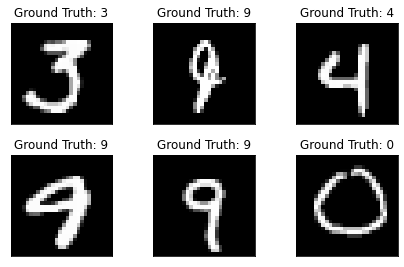

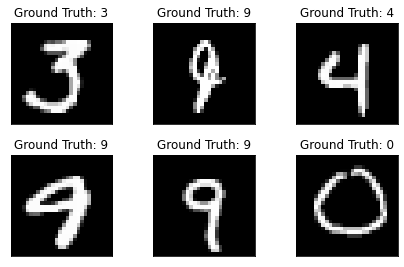

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### The Network
The `train` and `test` functions will be used to train the networks with different optimizers and will subsequently fill arrays that contain the data regarding the training and test loss. This will later be plotted for comparision. We will also store the time information.

Our network starts with two convolution layers of kernel size 5 each followed by two fully connected layers of size 50 and 10. The final fully connected layers has 10 outputs which map to the 10 classes available in the MNIST dataset. We also incorporate dropout and use ReLU as our activation function throughout the experiment.

We use the cross-entropy loss since we have a non-binary classification problem at our hands. 

In [6]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % h_params['log_interval'] == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [7]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

### Pre training
Before starting we show that the untrained network predicts each class with roughly the same weight. Hence we have an accuracy of ~ 10% as we have 10 classes and each class has an equal chance of getting selected by the untrained network. We can also see this visually as most of the labels are wrong.

F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)



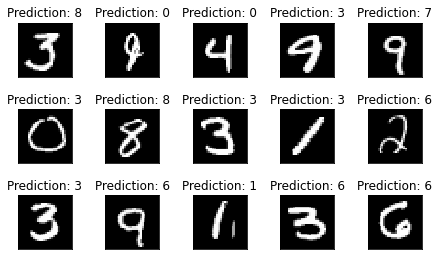

In [8]:
network = Net()

with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]


test()

## SGD
The first method we have is the stochastic gradient descent without momentum. We take independent identically distributed samples of data based on a batch size for each update. The batch size becomes another hyperparameter that we must care for during optimization.

$$\theta_{t+1}=\theta_{t}-\alpha \cdot \nabla_{\theta_t} J(\theta_{t+1}, x^{i:i+n}, y^{i:i+n})
$$

In [ ]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=0)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd = toc - tic

train_losses_sgd = train_losses.copy()
train_counter_sgd = train_counter.copy()
test_losses_sgd = test_losses.copy()
test_counter_sgd = test_counter.copy()

### Visualization of SGD without Momentum

We visualize the training progress of the stochastic gradient method without the use of momentum and the resultant classification on some text images.

In [ ]:
print("SGD Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd, train_losses_sgd, color='blue')
plt.scatter(test_counter_sgd, test_losses_sgd, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

# # fig

In [ ]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## SGD With Momentum

SGD can be very erratic as we can have sharp steps in directions that do not produce any meaningful reduction in the loss in the learnable parameter space. By applying the concept of momentum, we want the previous updates of our trainable parameters to have an effect on the current learning step. The addition of momentum helps the SGD to step in relevant directions and dampens movement in directions that have too much variance. 
$$v_{t} = \beta v_{t-1} - \alpha \nabla_{\theta_t} J(\theta_{t}, x^{i:i+n}, y^{i:i+n})$$
$$\theta_{t+1} =\theta_{t} + v_{t}$$

In [9]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=h_params['momentum'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd_momentum = toc - tic

train_losses_sgd_momentum = train_losses.copy()
train_counter_sgd_momentum = train_counter.copy()
test_losses_sgd_momentum = test_losses.copy()
test_counter_sgd_momentum = test_counter.copy()

F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.286680
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.255975
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.121904
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.800460
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.622887
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.234339
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.250031
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.974547
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.977719
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.941198
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.762683
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.910497
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.667589
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.795918
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.678890
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.853317
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.861698
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.739324
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.288084
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.158055
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.159974
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.298703
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.161853
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.222485
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.101690
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.244266
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.295567
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.257011
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.179953
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.285673
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.175567
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.257940
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.117212
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.312485
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.117246
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.300147
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.140860
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.262328


### Visualization of SGD with Momentum

We visualize the training progress of the stochastic gradient method with the use of momentum and the resultant classification on some text images.

In [ ]:
print("SGD With Momentum Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, color='blue')
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

In [ ]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Nesterov Momentum

We can also utilize the gradient of a future position for our update step instead of using the gradient at the current time step. For this reason, the Nestrov Momentum, or the look ahead momentum can be incorporated.

$$\theta^*_{t} = \theta_t + \beta v_{t-1} $$
$$v_{t} =\beta v_{t-1} - \alpha \nabla_{\theta_t} J(\theta^*_{t}, x^{i:i+n}, y^{i:i+n}) $$
$$\theta_{t+1} =\theta_{t} + v_{t}$$

In [ ]:
tic = timeit.default_timer()
network = Net()
optimizer = optim.SGD(network.parameters(), lr=h_params['learning_rate'],
                      momentum=h_params['momentum'], nesterov=True)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
toc = timeit.default_timer()
time_sgd_nestrov = toc - tic

train_losses_sgd_nestrov = train_losses.copy()
train_counter_sgd_nestrov = train_counter.copy()
test_losses_sgd_nestrov = test_losses.copy()
test_counter_sgd_nestrov = test_counter.copy()

### Visualization for Neterov Momentum

We visualize the training progress of the Neterov Momentum method and the resultant classification on some text images.

In [ ]:
print("Nestrov Took", time_sgd, "To Execute")

fig = plt.figure()
plt.plot(train_counter_sgd_nestrov, train_losses_sgd_nestrov, color='blue')
plt.scatter(test_counter_sgd_nestrov, test_losses_sgd_nestrov, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

test()

In [ ]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Comparision of SGD, SGD Momentum and Nestrov


We can see that SGD without momentum gets stuck at a worse local minimum compared to the momentum methods. We also see a steeper fall for both the momentum methods which signifies that we have significantly improved the learning speed of our neural network.

In [ ]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter_sgd, train_losses_sgd, label = "Training Loss SGD")
plt.scatter(test_counter_sgd, test_losses_sgd, label = "Test Loss SGD")
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, label = "Training Loss SGD With Momentum")
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, label = "Test Loss SGD With Momentum")
plt.plot(train_counter_sgd_nestrov, train_losses_sgd_nestrov, label = "Training Loss Nestrov Momentum")
plt.scatter(test_counter_sgd_nestrov, test_losses_sgd_nestrov, label = "Test Loss Nestrov Momentum")

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy Loss')
plt.show()
# # fig
# test_losses_sgd_nestrov

In [ ]:
fig.savefig("momentum_optimizer_comparision.pdf", bbox_inches='tight')

### ADAGrad

ADAgrad uses the idea of weighing each learnable parameter with a different step size during the optimization step. The main advantage is that we do not need to tune the learning rate $\alpha$ and implementations use a default value of 0.01 as the accumulated gradient information adjusts the step-size for us. This is significant since hyper parameter tuning is a time consuming process and the learning rate is one of the most crucial hyper parameters that is often extremely difficult to tune properly. 

$$\nu_{t}=\beta_{1} \nu_{t-1}+\left(1-\beta_{1}\right) g_{t}$$
$$V_{t}=\beta_{2} V_{t-1}+\left(1-\beta_{2}\right)\left(g_{t}\right)^{2}$$
$$\theta_{t+1}=m_{t}-\alpha \frac{\nu_{t}}{\sqrt{V_{t}}+\epsilon}$$

In [20]:
network = Net()
optimizer = optim.Adagrad(network.parameters(), lr=h_params['learning_rate'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
train_losses_adagrad = train_losses.copy()
test_losses_adagrad = test_losses.copy()
train_counter_adagrad = train_counter.copy()
test_counter_adagrad = test_counter.copy()


Test set: Avg. loss: 2.3165, Accuracy: 833/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314493
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.068327
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.513937
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.954260
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.996919
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.793965
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.762960
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.634957
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.566644
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.515703
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.413664
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.494134
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.639124
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.552194
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.554214
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.495738
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.684785
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.636517
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.348874
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.172870
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.212028
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.283412
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.131202
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.149527
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.421758
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.123126
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.319540
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.228589
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.130744
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.254211
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.239668
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.267063
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.166450
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.290942
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.160261
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.338730
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.169539
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.142419
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.182685


### Visualizing results from ADAGrad

In [1]:
fig = plt.figure()
plt.plot(train_counter_adagrad, train_losses_adagrad, color='blue')
plt.scatter(test_counter_adagrad, test_losses_adagrad, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig

NameError: name 'plt' is not defined

In [ ]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## ADAM

The ADAM method uses the best of both worlds to combine the momentum methods and the adaptive learning rate methods to give what is now the staple numerical optimzer in most deep learning projects. The method stores both the exponentially decaying average of past gradients sqsuares i.e. the second momentum, along with the exponentially decaying average of past gradients i.e. first momentums.

$$\nu_{t}=\beta_{1} \nu_{t-1}+\left(1-\beta_{1}\right) g_{t} $$
$$V_{t}=\beta_{2} V_{t-1}+\left(1-\beta_{2}\right)\left(g_{t}\right)^{2} $$
$$\hat{\nu_{t}}=\frac{\nu_{t}}{1-\beta_1}$$
$$\hat{V_{t}} = \frac{V_{t}}{1-\beta_2}$$
$$\theta_{t+1}=\theta_{t}-\alpha \frac{\hat{\nu_{t}}}{\sqrt{\hat{V_{t}}}+\epsilon}$$

In [10]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=h_params['learning_rate'])

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(h_params['n_epochs'] + 1)]

test()
for epoch in range(1, h_params['n_epochs'] + 1):
  train(epoch)
  test()
    
train_losses_adam = train_losses.copy()
train_counter_adam = train_counter.copy()
test_losses_adam = test_losses.copy()
test_counter_adam = test_counter.copy()


Test set: Avg. loss: 2.3150, Accuracy: 1123/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340430
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.870156
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.284156
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.314465
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.015254
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.901496
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.756172
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.969212
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.954948
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.679442
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.606833
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.798687
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.803341
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.397223
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.651044
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.594903
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.520968
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.457196
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.788930
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.304535
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.304347
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.591340
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.315126
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.282771
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.551888
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.429398
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.758295
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.213607
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.592294
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.481483
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.409629
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.487203
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.461895
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.649944
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.263740
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.436432
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.160177
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.379505
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.524967


### Visualizing the results form the ADAM Method

Text(0, 0.5, 'negative log likelihood loss')

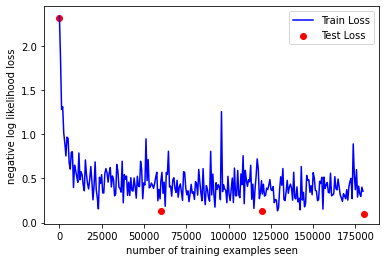

In [11]:
fig = plt.figure()
plt.plot(train_counter_adam, train_losses_adam, color='blue')
plt.scatter(test_counter_adam, test_losses_adam, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig

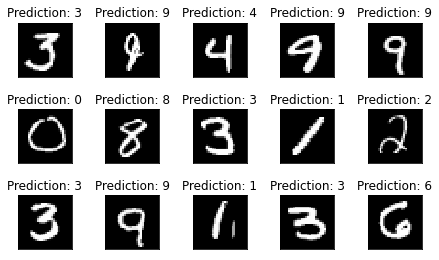

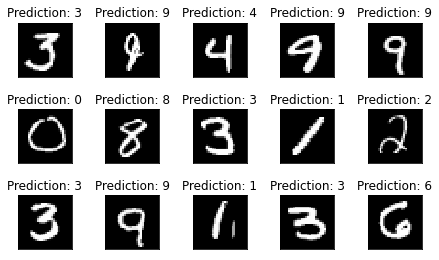

In [12]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## The non-convergence of Adaptive Methods

The ADAM method suffers from an important disadvantage as well in that, the method often does not converge. We can observe this by comparing it to SGD with momentum.

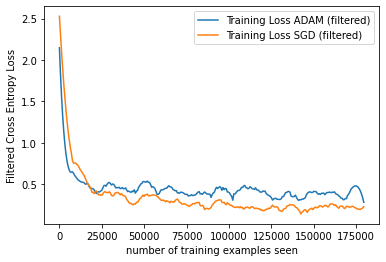

In [16]:
from scipy.signal import savgol_filter
fig, ax = plt.subplots()
box_pts=6
# box = np.ones(box_pts)/box_pts
adam_loss_moving_avg = savgol_filter(train_losses_adam, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_adam, adam_loss_moving_avg, label = 'Training Loss ADAM (filtered)')
# adagrad_loss_moving_avg = savgol_filter(train_losses_adagrad, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
# ax.plot(train_counter_adagrad, adagrad_loss_moving_avg, label = 'Training Loss ADAGrad (filtered)')
sgdm_loss_moving_avg = savgol_filter(train_losses_sgd_momentum, 21, 3) # np.convolve(train_losses_adam, box, mode='same')
ax.plot(train_counter_sgd_momentum, sgdm_loss_moving_avg, label = 'Training Loss SGD (filtered)')
plt.legend()
plt.xlabel('number of training examples seen')
plt.ylabel('Filtered Cross Entropy Loss')
fig.savefig('figures/adam_vs_sgdm.pdf')

### ADAM vs ADAgrad vs SGD Momentum

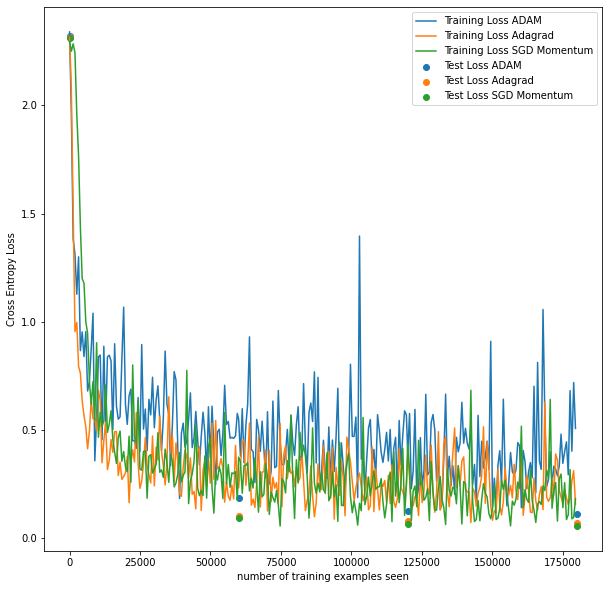

In [21]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter_adam, train_losses_adam, label = "Training Loss ADAM")
plt.scatter(test_counter_adam, test_losses_adam, label = "Test Loss ADAM")
plt.plot(train_counter_adagrad, train_losses_adagrad, label = "Training Loss Adagrad")
plt.scatter(test_counter_adagrad, test_losses_adagrad, label = "Test Loss Adagrad")
plt.plot(train_counter_sgd_momentum, train_losses_sgd_momentum, label = "Training Loss SGD Momentum")
plt.scatter(test_counter_sgd_momentum, test_losses_sgd_momentum, label = "Test Loss SGD Momentum")

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy Loss')
plt.show()
# # fig
# test_losses_sgd_nestrov

### LBFGS

We refer to the taylors expansion

$$J(\theta) \approx J(\theta_t)+\nabla J(\theta)^{\top} (\theta - \theta_t)+\frac{1}{2} (\theta - \theta_t)^{\top} \mathrm{H(\theta)} (\theta - \theta_t)$$

and approximate $H(\theta_t)$ with $H^{*}(\theta_t)$. The BFGS method stems from the Broyden's method where we iteratively build our matrix by minimizing the frobenius norm of $H^*_{t+1} - H^*_{t}$. We then make a minimal adjustment such that our matrix remains symmetric and positive definite. 

The BFGS method cannot be used to solve large scale problems due to the intense memory footprint that comes with generating a sequence of large matrices for high dimensional problems such as deep neural networks. The answer to this memory problem is the limited or L-BFGS method. The big difference is that we now only store a subset of the entire matrix by storing a few vectors out of the entire matrix. It is important to note that stochastic batches do not work well because it needs gradients of high quality in order to construct useful quadratic models and perform reliable line searches.

In [17]:
network = Net()
# lr need not be set
optimizer = optim.LBFGS(network.parameters(), lr=1)

train_losses = []
test_losses = []
train_counter_lbfgs = []
test_counter_lbfgs = [0,1,2,3,4,5,6]

train_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

test_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2500, shuffle=True)

def train_lbfgs():
    network.train()
    def closure():
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        return loss
    for epoch, (data, target) in enumerate(train_loader_second_order):
        if epoch <= 6:
            test()
            loss = optimizer.step(closure)
            train_losses.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_second_order.dataset),
                100. * batch_idx / len(train_loader_second_order), loss.item()))
            train_counter_lbfgs.append(epoch)
        else:
            break

    
tic = timeit.default_timer()
train_lbfgs()
toc = timeit.default_timer()

time_lbfgs = toc-tic

train_losses_lbfgs = train_losses.copy()
test_losses_lbfgs = test_losses.copy()


F:\Google Drive Waleed\Waleed\Masters\3rd Semester\Computational Aspects of Machine Learning\code\network.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\users\waleed bin khalid\appdata\local\programs\python\python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

### Visualizing results of the L-BFGS method

Text(0, 0.5, 'negative log likelihood loss')

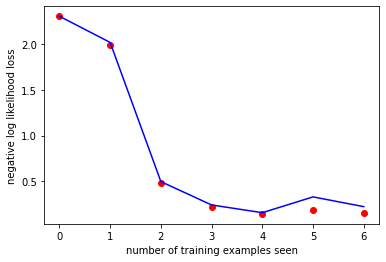

In [35]:
fig = plt.figure()
plt.plot(train_counter_lbfgs, train_losses_lbfgs, color='blue')
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

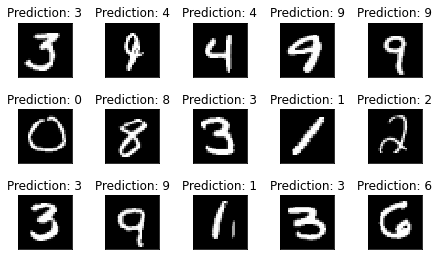

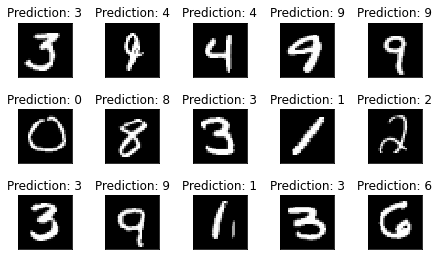

In [36]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Hessian Free

The Hessian Free method is very similar to the quasi Newton's method in that it uses local quadratic approximations for updates. However, unlike the previously discussed second order methods, if does not require any matrix inverse but rather uses the linear conjugate gradient method eliminating the need for the Hessian matrix.

Source: Optimization Code has been taken from https://github.com/moonl1ght/HessianFreeOptimization

In [65]:
from hf import HessianFree
network = Net()
# lr need not be set
optimizer = HessianFree(network.parameters())

train_losses = []
test_losses = []
train_counter_hf = []
test_counter_hf = [0,1,2,3,4,5,6]

train_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

test_loader_second_order = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=500, shuffle=True)

def train_hf():
    network.train()
    def closure():
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward(retain_graph=True)
        return loss, output
#     for epoch in range(5):
    for epoch, (data, target) in enumerate(train_loader_second_order):
        if epoch <= 6:
            test()
            loss = optimizer.step(closure)
            train_losses.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_second_order.dataset),
                100. * batch_idx / len(train_loader_second_order), loss.item()))
            train_counter_hf.append(epoch)
        else:
            break
                

tic = timeit.default_timer()
train_hf()
toc = timeit.default_timer()

time_hf = toc-tic
train_losses_hf = train_losses.copy()
test_losses_hf = test_losses.copy()


Test set: Avg. loss: 2.3146, Accuracy: 964/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.179443

Test set: Avg. loss: 2.1811, Accuracy: 2094/10000 (21%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.851286

Test set: Avg. loss: 1.8341, Accuracy: 2831/10000 (28%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.677523

Test set: Avg. loss: 1.6892, Accuracy: 3430/10000 (34%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.448120

Test set: Avg. loss: 1.4221, Accuracy: 5424/10000 (54%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.408845

Test set: Avg. loss: 1.4097, Accuracy: 5680/10000 (57%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.653013

Test set: Avg. loss: 0.6407, Accuracy: 8125/10000 (81%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.415755


### Visualizing results of the Hessian Free method

Text(0, 0.5, 'negative log likelihood loss')

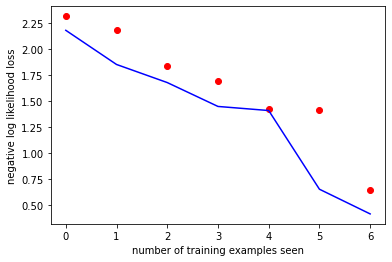

In [67]:
fig = plt.figure()
plt.plot(train_counter_hf, train_losses_hf, color='blue')
plt.scatter(test_counter_hf, test_losses_hf, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [ ]:
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Comparing L-BFGS with Hessian Free method

We observe that both methods require a very small number of very expensive iterations but the LBFGS method has a sharper fall which then settles at a more or less constant loss value.

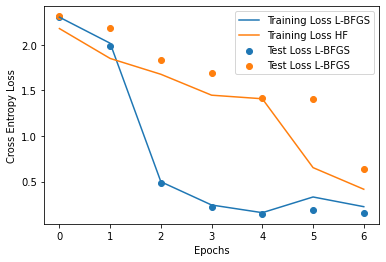

In [71]:
fig = plt.figure()
plt.plot(train_counter_lbfgs, train_losses_lbfgs, label = 'Training Loss L-BFGS')
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, label = 'Test Loss L-BFGS')
plt.plot(train_counter_hf, train_losses_hf, label = 'Training Loss HF')
plt.scatter(test_counter_hf, test_losses_hf, label = 'Test Loss L-BFGS')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.savefig("lbfgs_hf.pdf")

### Comparing time complexity of various first and second order methods

As expected we see that even though the second order methods have very few iteration counts, they require more time than the first order methods which have iteration counts that are orders of magnitude higher. This illustrates why the second order method despite their mathematic

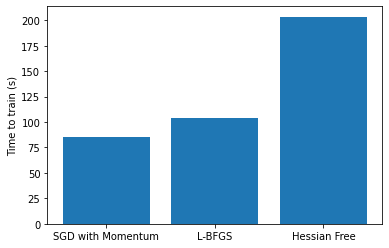

In [77]:
fig = plt.figure()
plt.bar(["SGD with Momentum", "L-BFGS", "Hessian Free"], [time_sgd_momentum, time_lbfgs, time_hf])
plt.ylabel("Time to train (s)")
fig.savefig("execution_time.pdf")

## Newton-CG
Source: The code for the optimizer has been taken from: https://github.com/severin617/Newton-CG

## Comparision between different optimizers

Text(0, 0.5, 'negative log likelihood loss')

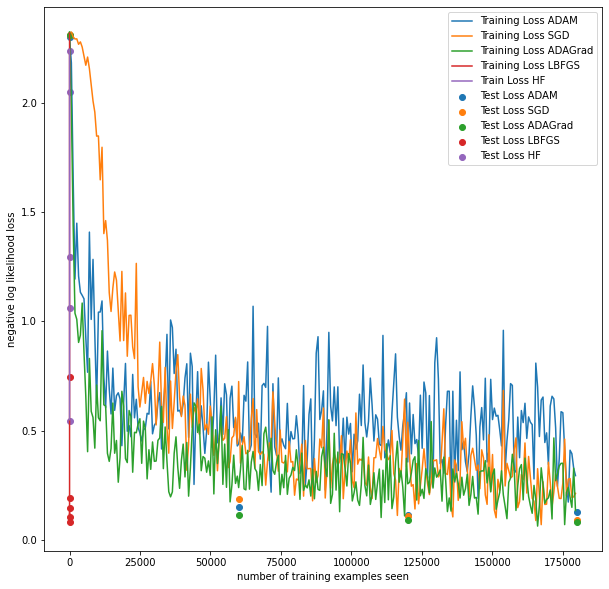

In [175]:
fig = plt.figure(figsize = (10,10))
plt.plot(train_counter, train_losses_adam, label = "Training Loss ADAM")
plt.scatter(test_counter, test_losses_adam, label = "Test Loss ADAM")
plt.plot(train_counter, train_losses_sgd, label = "Training Loss SGD")
plt.scatter(test_counter, test_losses_sgd, label = "Test Loss SGD")
plt.plot(train_counter, train_losses_adagrad, label = "Training Loss ADAGrad")
plt.scatter(test_counter, test_losses_adagrad, label = "Test Loss ADAGrad")
plt.plot(train_counter_lbfgs, train_losses_lbfgs, label = "Training Loss LBFGS")
plt.scatter(test_counter_lbfgs, test_losses_lbfgs, label = "Test Loss LBFGS")
plt.plot(train_counter_lbfgs, train_losses_hf, label = "Train Loss HF")
plt.scatter(test_counter_lbfgs, test_losses_hf,  label = "Test Loss HF")
# plt.plot(train_counter, train_losses_lbfgs, label = "Training Loss LBFGS")
# plt.scatter(test_counter, test_losses_lbfgs, label = "Test Loss LBFGS")
plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# # fig